## 1. Importing libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from xgboost import XGBClassifier
# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

## 2. Load Dataset

In [13]:
df = pd.read_csv(r"/Users/harikasunkara/Desktop/clinical+genomic_split.csv")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (618, 20)
Columns: ['case_id', 'gender', 'age_diag', 'grade', 'cancer_history', 'ajcc_path_tumor_pt', 'ajcc_path_nodes_pn', 'ajcc_clin_metastasis_cm', 'ajcc_path_metastasis_pm', 'ajcc_path_tumor_stage', 'vital_status_12', 'race_Asian', 'race_Black or African American', 'race_Hispanic or Latino', 'race_White', 'race_other', 'VHL_mutation', 'PBMR1_mutation', 'TTN_mutation', 'Split']


,case_id,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,ajcc_path_tumor_stage,vital_status_12,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split
0,C3L-00004,1,6.0,3,NaN,7,0,1,0,3,1,0,0,0,1,0,1,1,0,train
1,C3L-00010,1,1.0,3,NaN,3,1,1,0,1,1,0,0,0,1,0,1,0,0,train
2,C3L-00011,0,5.0,4,1.0,8,0,2,2,3,0,0,0,0,1,0,1,0,1,train
3,C3L-00026,0,5.0,3,NaN,2,0,1,0,1,1,0,0,0,1,0,1,0,1,train
4,C3L-00079,1,3.0,3,NaN,8,2,1,0,3,0,0,0,0,1,0,1,0,0,train


## 3. Basic EDA

In [3]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)


Missing values per column:
 case_id                             0
gender                              0
age_diag                           17
grade                               0
cancer_history                    545
ajcc_path_tumor_pt                  0
ajcc_path_nodes_pn                  0
ajcc_clin_metastasis_cm             0
ajcc_path_metastasis_pm             0
ajcc_path_tumor_stage               0
vital_status_12                     0
race_Asian                          0
race_Black or African American      0
race_Hispanic or Latino             0
race_White                          0
race_other                          0
VHL_mutation                        0
PBMR1_mutation                      0
TTN_mutation                        0
Split                               0
dtype: int64

Data types:
 case_id                            object
gender                              int64
age_diag                          float64
grade                               int64
cancer_history  

In [23]:
counts = df['cancer_history'].value_counts(dropna=False)
percentages = (counts / len(df)) * 100

print("Counts:\n", counts)
print("\nPercentages:\n", percentages)


Counts:
 cancer_history
NaN    545
1.0     73
Name: count, dtype: int64

Percentages:
 cancer_history
NaN    88.187702
1.0    11.812298
Name: count, dtype: float64


| Cancer History             | Count (%)  | Meaning                                 |
| -------------------------- | ---------- | --------------------------------------- |
| **0 (No cancer history)**  | **88.19%** | Patients with no previous cancer record |
| **1 (Yes cancer history)** | **11.81%** | Patients with a prior history of cancer |


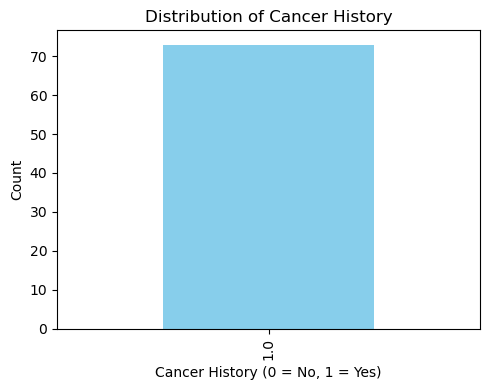

In [19]:
plt.figure(figsize=(5,4))
df['cancer_history'].value_counts().plot(kind='bar',color=['skyblue', 'salmon'])
plt.title('Distribution of Cancer History')
plt.xlabel('Cancer History (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 🩺 Interpretation:
Most patients (nearly 9 out of 10) have no prior cancer history, meaning the dataset is dominated by first-time cancer cases.

In [20]:
print("\nVital status value counts:\n", df['vital_status_12'].value_counts())
print("\nVital status percentage:\n", df['vital_status_12'].value_counts(normalize=True) * 100)


Vital status value counts:
 vital_status_12
1    543
0     75
Name: count, dtype: int64

Vital status percentage:
 vital_status_12
1    87.864078
0    12.135922
Name: proportion, dtype: float64


| Vital Status     | Count (%)  | Meaning                                       |
| ---------------- | ---------- | --------------------------------------------- |
| **1 (Alive)**    | **87.86%** | Patients who survived after 12 months         |
| **0 (Deceased)** | **12.14%** | Patients who did not survive within 12 months |

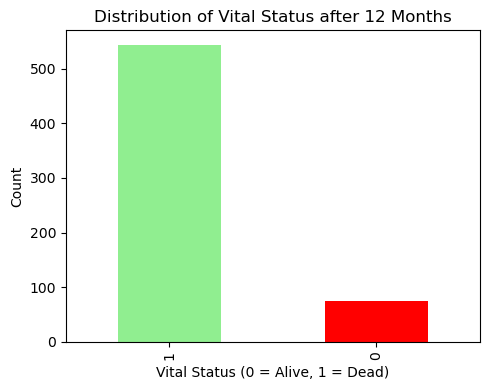

In [24]:
plt.figure(figsize=(5,4))
df['vital_status_12'].value_counts().plot(kind='bar',color=['lightgreen', 'red'])
plt.title('Distribution of Vital Status after 12 Months')
plt.xlabel('Vital Status (0 = Alive, 1 = Dead)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## ⚕️ Interpretation:
The dataset contains both alive and deceased patients, confirming it includes a mix of healthy and cancer-affected cases, suitable for survival prediction modeling.

## 4. Handle Missing Values

In [25]:
# Fill missing 'cancer_history' with 0 (assume no prior cancer)
if 'cancer_history' in df.columns:
    df['cancer_history'] = df['cancer_history'].fillna(0)

# Fill missing 'gender' with the mode (most frequent)
if 'gender' in df.columns and df['gender'].isnull().sum() > 0:
    df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

# Fill missing 'age_diag' with median age
if 'age_diag' in df.columns and df['age_diag'].isnull().sum() > 0:
    df['age_diag'] = df['age_diag'].fillna(df['age_diag'].median())

print("\nMissing values AFTER cleaning:\n", df.isnull().sum())



Missing values AFTER cleaning:
 case_id                           0
gender                            0
age_diag                          0
grade                             0
cancer_history                    0
ajcc_path_tumor_pt                0
ajcc_path_nodes_pn                0
ajcc_clin_metastasis_cm           0
ajcc_path_metastasis_pm           0
ajcc_path_tumor_stage             0
vital_status_12                   0
race_Asian                        0
race_Black or African American    0
race_Hispanic or Latino           0
race_White                        0
race_other                        0
VHL_mutation                      0
PBMR1_mutation                    0
TTN_mutation                      0
Split                             0
dtype: int64


## 5. Separate Target First

In [26]:
# Target: 0 = Alive, 1 = Dead
# Target
y = df['vital_status_12']

# Drop target and non-numeric columns
X = df.drop(columns=['vital_status_12', 'case_id', 'Split'])

print(X.dtypes)

gender                              int64
age_diag                          float64
grade                               int64
cancer_history                    float64
ajcc_path_tumor_pt                  int64
ajcc_path_nodes_pn                  int64
ajcc_clin_metastasis_cm             int64
ajcc_path_metastasis_pm             int64
ajcc_path_tumor_stage               int64
race_Asian                          int64
race_Black or African American      int64
race_Hispanic or Latino             int64
race_White                          int64
race_other                          int64
VHL_mutation                        int64
PBMR1_mutation                      int64
TTN_mutation                        int64
dtype: object


## 8. Train–Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTraining data size:", X_train.shape)
print("Testing data size:", X_test.shape)


Training data size: (494, 17)
Testing data size: (124, 17)


## 9. Feature Scaling (only numeric)

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nExample of scaled features (first 5 rows):")
print(X_train[:5])


Example of scaled features (first 5 rows):
[[ 0.72111026 -0.45877607  0.395257   -0.35756661  1.08889055  0.96841575
  -0.45209797  1.51800102  1.5792427  -0.18878404 -0.22098025 -0.04503773
   0.35395584 -0.14373989 -1.47542509 -1.42640908 -1.43390391]
 [-1.38675049  0.37751684 -0.84054653 -0.35756661 -0.44712296  0.96841575
  -0.45209797  0.28055464 -0.81629229 -0.18878404 -0.22098025 -0.04503773
   0.35395584 -0.14373989 -0.22951057 -0.06345727  0.09600653]
 [-1.38675049 -1.29506898 -0.84054653  2.79668171 -0.44712296 -0.49011285
  -0.45209797  0.28055464 -0.81629229 -0.18878404 -0.22098025 -0.04503773
   0.35395584 -0.14373989  1.01640395  1.29949454  1.62591696]
 [ 0.72111026 -1.29506898  0.395257   -0.35756661 -0.44712296 -0.49011285
  -0.45209797  0.28055464 -0.81629229 -0.18878404 -0.22098025 -0.04503773
   0.35395584 -0.14373989  1.01640395  1.29949454  0.09600653]
 [ 0.72111026  1.21380975 -0.84054653 -0.35756661 -0.44712296 -0.49011285
   0.83886386  0.28055464 -0.81629229 

## 10. Define Models (with Imbalance Handling)

In [29]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"\nscale_pos_weight for XGBoost: {scale_pos_weight:.2f} (neg/pos = {neg}/{pos})")

trained_models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=200
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}


scale_pos_weight for XGBoost: 0.14 (neg/pos = 60/434)


## 11. Train & Evaluate Models

In [30]:
results = {}

for name, model in trained_models.items():
    print(f"\n================= {name} =================")
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # probability of class 1 (Dead)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cls_report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    # Save
    results[name] = {
        "model": model,
        "Accuracy": acc,
        "ROC-AUC": auc,
        "Classification": classification_report(y_test, y_pred, output_dict=True),
        "Confusion": cm,
        "y_prob": y_prob
    }

    # Print summary
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("\nClassification Report:\n", cls_report)
    print("Confusion Matrix:\n", cm)




================= Logistic Regression =================
Accuracy: 0.6532
ROC-AUC: 0.6648

Classification Report:
               precision    recall  f1-score   support

           0     0.1957    0.6000    0.2951        15
           1     0.9231    0.6606    0.7701       109

    accuracy                         0.6532       124
   macro avg     0.5594    0.6303    0.5326       124
weighted avg     0.8351    0.6532    0.7126       124

Confusion Matrix:
 [[ 9  6]
 [37 72]]

================= Random Forest =================
Accuracy: 0.9194
ROC-AUC: 0.8630

Classification Report:
               precision    recall  f1-score   support

           0     0.7778    0.4667    0.5833        15
           1     0.9304    0.9817    0.9554       109

    accuracy                         0.9194       124
   macro avg     0.8541    0.7242    0.7693       124
weighted avg     0.9120    0.9194    0.9104       124

Confusion Matrix:
 [[  7   8]
 [  2 107]]

================= XGBoost ===============

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:19:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 12. Bar Charts: Recall & F1-score

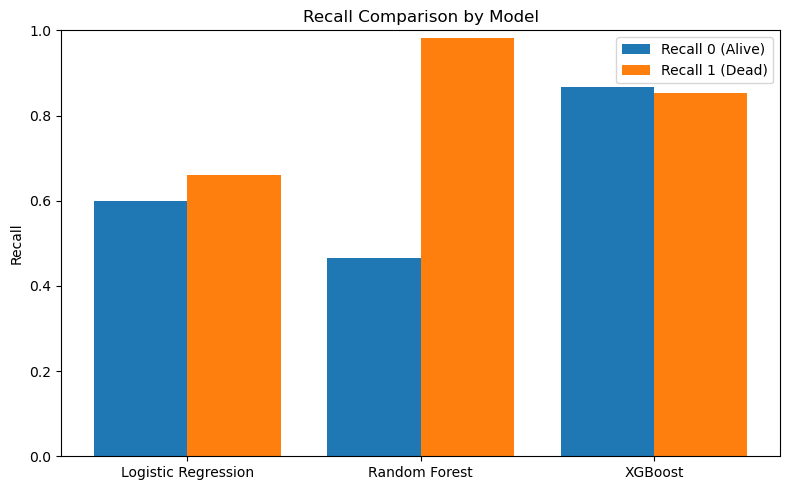

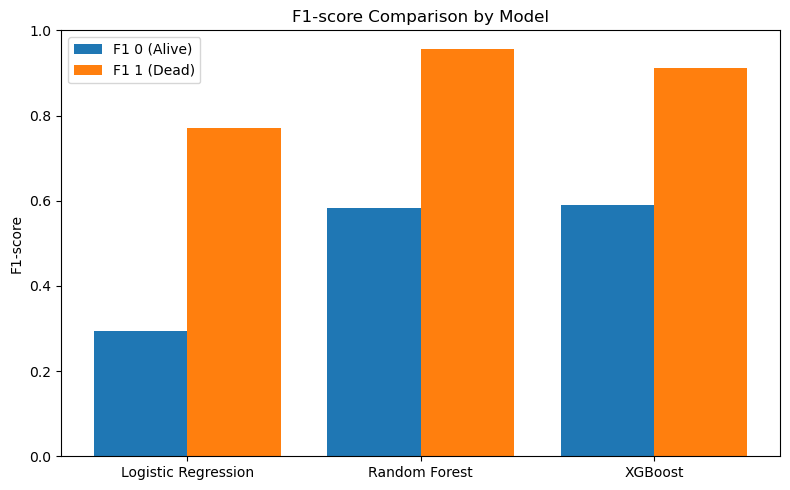

In [31]:
models_list = list(results.keys())

# In these labels: 0 = Alive, 1 = Dead
recall_0 = [results[m]['Classification']['0']['recall'] for m in models_list]
recall_1 = [results[m]['Classification']['1']['recall'] for m in models_list]
f1_0     = [results[m]['Classification']['0']['f1-score'] for m in models_list]
f1_1     = [results[m]['Classification']['1']['f1-score'] for m in models_list]

x = np.arange(len(models_list))

# Recall
plt.figure(figsize=(8,5))
plt.bar(x - 0.2, recall_0, width=0.4, label='Recall 0 (Alive)')
plt.bar(x + 0.2, recall_1, width=0.4, label='Recall 1 (Dead)')
plt.xticks(x, models_list)
plt.ylabel("Recall")
plt.title("Recall Comparison by Model")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# F1-score
plt.figure(figsize=(8,5))
plt.bar(x - 0.2, f1_0, width=0.4, label='F1 0 (Alive)')
plt.bar(x + 0.2, f1_1, width=0.4, label='F1 1 (Dead)')
plt.xticks(x, models_list)
plt.ylabel("F1-score")
plt.title("F1-score Comparison by Model")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


## 13. Confusion Matrix Heatmaps

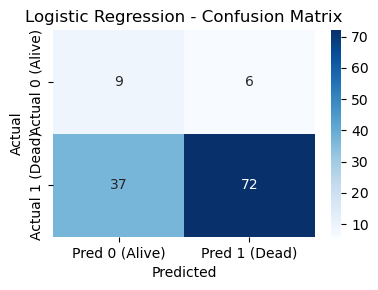

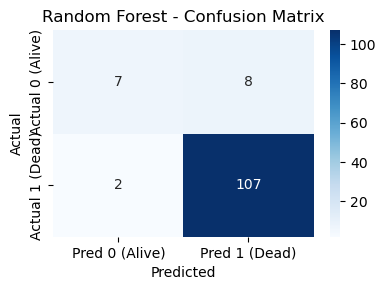

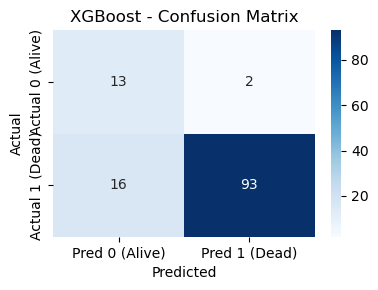

In [32]:
for m in models_list:
    cm = results[m]['Confusion']
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Pred 0 (Alive)', 'Pred 1 (Dead)'],
        yticklabels=['Actual 0 (Alive)', 'Actual 1 (Dead)']
    )
    plt.title(f"{m} - Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


## 14. ROC Curves

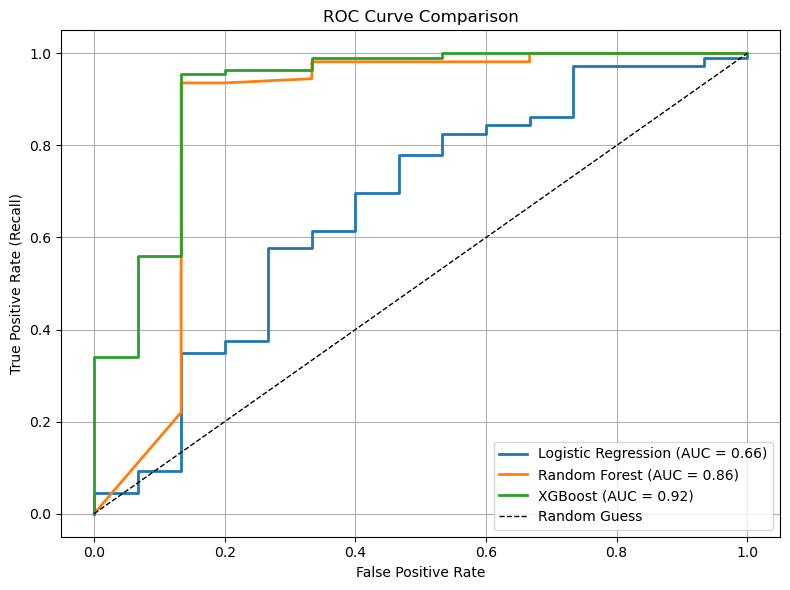

In [33]:
plt.figure(figsize=(8,6))

for m in models_list:
    y_prob = results[m]['y_prob']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = results[m]['ROC-AUC']
    plt.plot(fpr, tpr, lw=2, label=f"{m} (AUC = {auc:.2f})")

# Diagonal (random)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feed-Forward Neural Network (FFNN)

In [37]:
# Model definition
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary output
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
history = nn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7671 - loss: 0.5547 - val_accuracy: 0.8687 - val_loss: 0.5033
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.4078 - val_accuracy: 0.8687 - val_loss: 0.5133
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3891 - val_accuracy: 0.8687 - val_loss: 0.5005
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3631 - val_accuracy: 0.8687 - val_loss: 0.4831
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3342 - val_accuracy: 0.8687 - val_loss: 0.4606
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3387 - val_accuracy: 0.8687 - val_loss: 0.4474
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3158 - val_accuracy: 0.8687 - val_loss: 0.4364
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8861 - loss: 0.3080 - val_accuracy: 0.8687 - val_loss:

## Evaluation


In [38]:
y_prob_nn = nn_model.predict(X_test).ravel()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

# Print classification report
print("\nNeural Network Classification Report:\n")
print(classification_report(y_test, y_pred_nn, digits=4))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Neural Network Classification Report:

              precision    recall  f1-score   support

           0     0.7500    0.4000    0.5217        15
           1     0.9224    0.9817    0.9511       109

    accuracy                         0.9113       124
   macro avg     0.8362    0.6908    0.7364       124
weighted avg     0.9016    0.9113    0.8992       124



### AUC

In [39]:
auc_nn = roc_auc_score(y_test, y_prob_nn)
print("Neural Network ROC-AUC:", auc_nn)

Neural Network ROC-AUC: 0.8581039755351682


### Confusion matrix


Confusion Matrix:
 [[  6   9]
 [  2 107]]


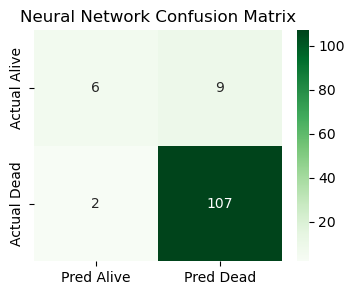

In [40]:
cm_nn = confusion_matrix(y_test, y_pred_nn)
print("\nConfusion Matrix:\n", cm_nn)

# Plot confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Alive', 'Pred Dead'],
            yticklabels=['Actual Alive', 'Actual Dead'])
plt.title("Neural Network Confusion Matrix")
plt.show()

### ROC curve

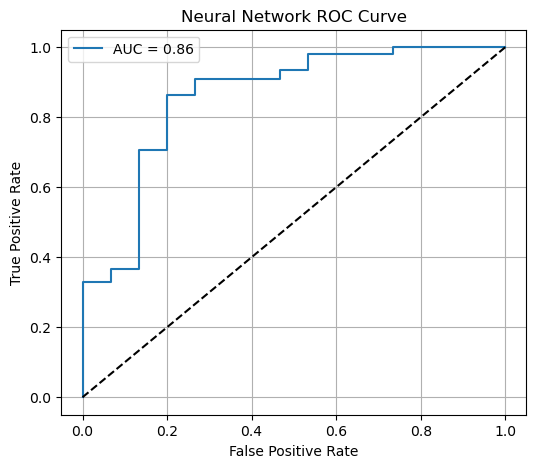

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_nn)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_nn:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights)

# Rebuild improved model
nn_model2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

nn_model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = nn_model2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    class_weight=class_weights,   # <<< IMPORTANT
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

# Predictions
y_prob_nn2 = nn_model2.predict(X_test).ravel()
y_pred_nn2 = (y_prob_nn2 >= 0.40).astype(int)   # lower threshold improves recall

print("\nImproved NN Classification Report:\n")
print(classification_report(y_test, y_pred_nn2))

print("New AUC:", roc_auc_score(y_test, y_prob_nn2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn2))


Class Weights: {0: 4.116666666666666, 1: 0.5691244239631337}
Epoch 1/80


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5418 - loss: 0.7049 - val_accuracy: 0.7071 - val_loss: 0.6553
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5595 - loss: 0.6616 - val_accuracy: 0.6364 - val_loss: 0.6707
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5544 - loss: 0.6526 - val_accuracy: 0.6768 - val_loss: 0.6716
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6380 - loss: 0.6169 - val_accuracy: 0.6566 - val_loss: 0.6538
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6329 - loss: 0.6064 - val_accuracy: 0.6263 - val_loss: 0.6608
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6481 - loss: 0.5855 - val_accuracy: 0.6566 - val_loss: 0.6370
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7038 - loss: 0.5907 - val_accuracy: 0.6465 - val_loss: 0.6339
Epoch 8/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7215 - loss: 0.5452 - val_accuracy: 0.6364 - val_loss: 0.6367
Epo

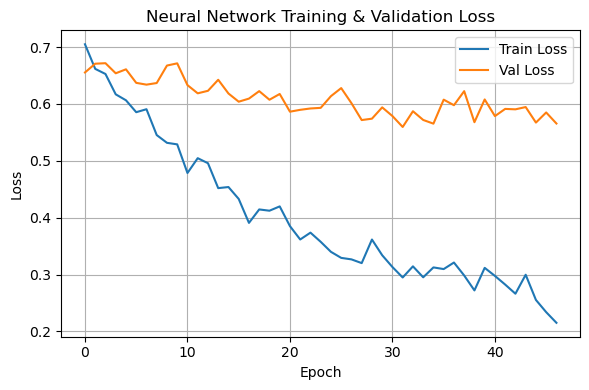

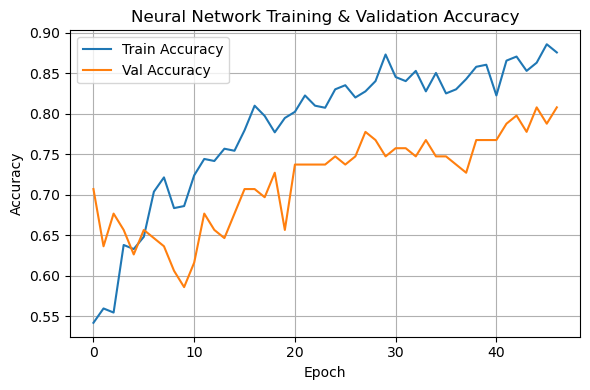

In [44]:
import matplotlib.pyplot as plt

# Training & validation loss
plt.figure(figsize=(6,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Training & validation accuracy
plt.figure(figsize=(6,4))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Neural Network Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Confusion Matrix:
 [[11  4]
 [13 96]]


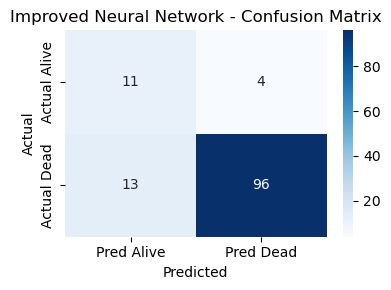

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_nn2 = confusion_matrix(y_test, y_pred_nn2)
print("Confusion Matrix:\n", cm_nn2)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm_nn2,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred Alive', 'Pred Dead'],
    yticklabels=['Actual Alive', 'Actual Dead']
)
plt.title("Improved Neural Network - Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

Improved NN AUC: 0.8605504587155963


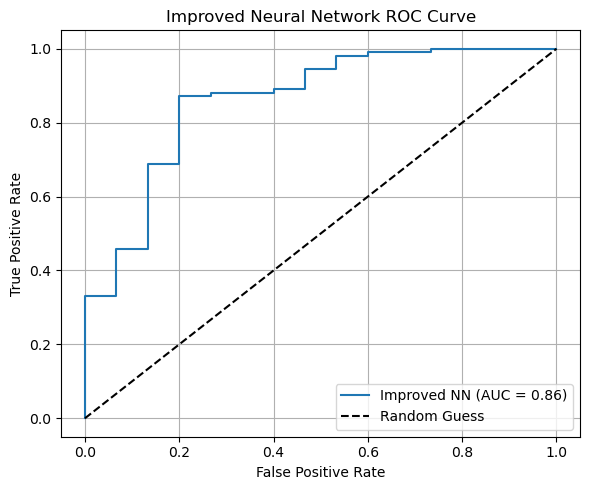

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_nn2, tpr_nn2, _ = roc_curve(y_test, y_prob_nn2)
auc_nn2 = roc_auc_score(y_test, y_prob_nn2)
print("Improved NN AUC:", auc_nn2)

plt.figure(figsize=(6,5))
plt.plot(fpr_nn2, tpr_nn2, label=f"Improved NN (AUC = {auc_nn2:.2f})")
plt.plot([0,1],[0,1],'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Improved Neural Network ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
